In [2]:
print(sc.uiWebUrl)

http://midway3-0066.rcc.local:4040


In [39]:
! squeue -u yjia2

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          40695181   caslake _interac    yjia2  R    5:03:55      1 midway3-0066


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/home/yjia2/fonts/NotoSansCJKsc-Regular.otf"  
fm.fontManager.addfont(font_path)
zh_font = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = zh_font.get_name()
plt.rcParams["axes.unicode_minus"] = False

from pyspark.sql import functions as F, types as T
from pyspark.ml.functions import vector_to_array
from pyspark.storagelevel import StorageLevel
from pyspark.ml.feature import Word2VecModel
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.feature import Word2Vec
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA

# Investigate the Method's Current Usage

Recent research in political science and sustainable development studies demonstrates that Principal Component Analysis (PCA) remains a vital tool for reducing the dimensionality of high-dimensional data and revealing underlying political, institutional, or economic structures. The following three selected peer-reviewed articles—"Exploring Political Personality" (Lewis, 2021), "Mapping the Political Space in Lithuania" (2019), and "Decoupling Renewable Energy, Green Finance, and Political Stability" (Behera et al., 2024)—showcase three different yet complementary applications of PCA.

The first article, "Exploring Political Personality," uses PCA to analyze survey-based personality trait measurements of local Chinese officials to identify potential personality dimensions influencing policy innovation. Instead of processing dozens of personality indicators independently, PCA extracts aggregated behavioral dimensions (e.g., openness, confidence) that effectively predict officials' propensity for innovative governance. Here, Principal Component Analysis (PCA) acts as a theoretical bridge: it reveals underlying structures that are not directly observable but have explanatory power for political behavior.

The second article, "A Political Space Map of Lithuania," uses Principal Component Analysis (PCA) to identify the ideological dimensions that co-construct the attitudes of political elites and voters. By applying PCA to high-dimensional issue position data, the authors reveal a two-dimensional political space (economic left-right and socio-cultural liberal-conservative). PCA is crucial because it transforms hundreds of issue-level survey variables into a coherent geometric map, revealing political competition, ideological clustering, and the divergence between voters and elites.

The third article, "Decoupling Renewable Energy, Green Finance, and Political Stability" (Behera et al., 2023), uses PCA as part of its institutional indicator variable construction and data preprocessing strategy to reduce measurement noise and multicollinearity. PCA allows the authors to condense multiple governance or risk indicators into a composite index, thereby constructing a more stable regression model.

In these studies, PCA is used to: (1) compress complex political data into an interpretable underlying structure; (2) reveal underlying ideological or behavioral dimensions; and (3) construct composite indicators from relevant variables. These applications directly referenced my project: research on the semantic evolution of the word "people" requires mapping high-dimensional word embedding spaces onto interpretable political semantic axes. Previous literature's use of PCA validates the use of dimensionality reduction methods to reveal underlying structures—in my research, the semantic field surrounding the word "people." Just as PCA can reveal underlying ideologies or personality traits, in my project, PCA also reveals the underlying semantic structure of Chinese political discourse, helping to explain how the meaning of the word "people" has changed across different political contexts and historical periods.

Behera, B., Mishra, M., & Sethi, N. (2023). Decoupling the role of renewable energy, green finance and political stability in achieving the sustainable development goal 13: Empirical insight from emerging economies. Sustainable Development, 32(1), 141–155.

Lewis, O. A. (2021). Exploring political personalities: The micro-foundation of local policy innovation in China. Governance, 34(4), 979–998.

Ramonaitė, A., Morkevičius, V., & Butkutė, R. (2019). Mapping the political space in Lithuania: The discrepancy between party elites and party supporters. European Political Science Review, 11(1), 39–59.

# Test the Method on Your Data

My project aims to explore the diachronic evolution of the political concept of "people" in Chinese political discourse. To achieve this, extensive EDA is required as preliminary exploration. Therefore, I hope to first examine the position of this political concept within the broader semantic field of Chinese political discourse using PCA. The overall project will consist of a four-stage computational process: 
- Text Preprocessing and Tokenization
- Learning High-Dimensional Word Embeddings
- Selecting a Political Lexicon Around "People"
- PCA on the Political Semantic Matrix.

### Text Preprocessing and Tokenization

I first processed a corpus of over 22GB of People's Daily articles (1947-2024), stored in partitioned Parquet format. Using PySpark:

- Clean the text and normalize the patterns
- Remove noise, such as punctuation and blank lines
- Segment the Chinese text into tokens
- Filter out extremely short sentences
- Retain only the necessary columns (year, cleaned content, tokens)

This created a scalable distributed DataFrame suitable for subsequent modeling.

In [16]:
BASE_PATH = "cleaned_segmented_parquet"
df = spark.read.parquet(BASE_PATH)

df = (df.withColumnRenamed("文本内容_清洗", "content_cleaned")
        .withColumnRenamed("年份", "year"))

df = df.select("content_cleaned", "year")

# Ensure that year is an integer.
df = df.withColumn("year", F.col("year").cast("int"))

print("Columns now:", df.columns)
df.printSchema()
df.show(5, truncate=80)

Columns now: ['content_cleaned', 'year']
root
 |-- content_cleaned: string (nullable = true)
 |-- year: integer (nullable = true)

+---------------------------------------------------------------------------------------------------------------------------------------+----+
|                                                                                                                        content_cleaned|year|
+---------------------------------------------------------------------------------------------------------------------------------------+----+
| 首届 动漫 版权保护 贸易 博览会 本报 广州 月 日电 记者 吴冰 贺林平 首届 中国 国际 影视 动漫 版权保护 贸易 博览会 东莞 这是 全国 第一...|2010|
|    数字 点击 成就 万吨 截至 年 月 日 大庆油田 年 生产 原油 万吨 天然气 亿立方米 原油 万吨 稳产 年 汪 波 宝 峰 亿元 财政部 会同 民政...|2010|
|     福建 铁路 三线 开通 六线 一站 开工 年 月 日 福厦 铁路 开通 建设者 欢呼雀跃 当日 福建 温 州 福 州 铁路 福厦 铁路 横 峰福 州 铁路...|2010|
|强化 廉政 意识 弘扬 新风 正气 深入开展 反腐倡廉 二 九年 反腐倡廉 宣传教育 工作 综述 本报记者 姜 洁 年 纪检监察 机关 贯彻落实 科学 发...|2010|
|   汽车 以旧换新 补贴 标准 上限 提高 万元 已 按原 标准 领取 补贴 车主 获补 差额 本报 北京 月 日电 记者 崔鹏 完善 汽车 以旧换新 

In [ ]:
# content_cleaned -> tokens (array)
df = df.withColumn("content_cleaned", F.trim(F.col("content_cleaned")))
df = df.filter(F.col("content_cleaned").isNotNull() 
               & (F.length("content_cleaned") > 0))

# Split the tokens into arrays based on blank spaces and remove any empty tokens.
df = df.withColumn("tokens", F.split(F.col("content_cleaned"), r"\s+"))
df = df.withColumn("tokens", F.expr("filter(tokens, x -> x <> '')"))

# Filter invalid samples (discard sentences with a length < 3).
df = df.withColumn("len_tokens", F.size(F.col("tokens")))
df = df.filter(F.col("len_tokens") >= 3).drop("len_tokens")

df = df.select("year", "content_cleaned", "tokens")

# Annual Coverage Check
year_stats = (
    df.groupBy("year")
      .agg(
          F.count("*").alias("n_docs"),
          F.sum(F.size("tokens")).alias("n_tokens") 
      )
      .orderBy("year")
)

year_stats.show(5, truncate=False)

[Stage 15:=====================================================>(250 + 1) / 251]

+----+------+--------+
|year|n_docs|n_tokens|
+----+------+--------+
|1947|10769 |2711874 |
|1948|8246  |2296198 |
|1949|18956 |5181229 |
|1950|19990 |6268532 |
|1951|13756 |5049297 |
+----+------+--------+
only showing top 5 rows



### Learning High-Dimensional Word Embeddings 

Since PCA requires numerical vectors as input, I trained a 150-dimensional Word2Vec model using Spark ML. The output is a vocabulary containing approximately 270,919 political and ideological terms, each represented as a 150-dimensional vector. These word embeddings will serve as the feature matrix for PCA.

In [ ]:
W2V_PARAMS = dict(
    vectorSize=150,    
    windowSize=6,      
    minCount=30,       
    maxIter=3,         # epochs
    stepSize=0.025,    # Learning rate
    numPartitions=100,  
    maxSentenceLength=600,  
    seed=42,
    inputCol="tokens",
    outputCol="w2v_features" 
)

In [ ]:
df_train = df.select("tokens")                     

# Memory + Disk (Serialization)
df_train = df_train.persist(StorageLevel.MEMORY_AND_DISK)   

w2v = Word2Vec(**W2V_PARAMS)
w2v_model = w2v.fit(df_train)

# Release the training corpus cache after training is complete.
df_train.unpersist()   

# Disk Layout (Model + Word Vector Table)
MODEL_DIR = "w2v_models/pd_w2v_vs200_mc10_ep5_ws8" 
w2v_model.write().overwrite().save(MODEL_DIR)

vecs = w2v_model.getVectors()   # [word: string, vector: vector]
vecs.write.mode("overwrite").parquet(f"{MODEL_DIR}/vectors_parquet")

In [4]:
MODEL_DIR = "w2v_models/pd_w2v_vs200_mc10_ep5_ws8"

# Load trained model
w2v_model = Word2VecModel.load(MODEL_DIR)

# Load vectors table
vecs = spark.read.parquet(f"{MODEL_DIR}/vectors_parquet")

In [5]:
vecs.printSchema()
vocab_size = vecs.count()
print("vocab_size =", vocab_size)

root
 |-- word: string (nullable = true)
 |-- vector: vector (nullable = true)

vocab_size = 270919


In [6]:
# Take one vector and print its length
sample_vec = vecs.select("vector").head()[0]
print("vector dimension =", len(sample_vec))


vector dimension = 150


In [7]:
vecs_arr = vecs.withColumn("arr", vector_to_array("vector"))

vecs_norm = vecs_arr.withColumn(
    "norm",
    F.sqrt(F.aggregate("arr", F.lit(0.0), lambda acc, x: acc + x * x))
)

vecs_norm.select(
    F.mean("norm").alias("mean_norm"),
    F.stddev("norm").alias("std_norm"),
    F.min("norm").alias("min_norm"),
    F.max("norm").alias("max_norm")
).show()


[Stage 8:>                                                        (0 + 16) / 16]

+-----------------+------------------+------------------+------------------+
|        mean_norm|          std_norm|          min_norm|          max_norm|
+-----------------+------------------+------------------+------------------+
|2.947684990033686|0.6449949248816662|0.9930399760928611|11.738858071774484|
+-----------------+------------------+------------------+------------------+



### Selecting a Political Lexicon Around “People”

To make PCA interpretable, I curated a focused lexicon of ~200–300 political terms that directly relate to:

- The masses / workers / peasants
- The state / government / institutions
- Political system: rule of law, elections, oversight, constitution
- Ideology: socialism, reform and opening up, common prosperity
- Security / stability / military / party discipline
- Development / science and technology / innovation

This curated lexicon forms the semantic space where “people” is situated.

In [ ]:
target_words = [

    # The masses / workers / peasants
    "人民","群众","工人","农民","干部","农民工","青年","妇女","大众","职工","工友","乡亲","同胞","同学",
    "居民","公民","党员","社员","劳动者","员工","退伍军人","志愿者","基层群众","基层干部",
    "教师","医务人员","学生","患者","老百姓","村民","市民","工人阶级","劳动阶级","群众代表",
    "人民群众","人民代表","人民团体","人民子弟兵","人民军队","人民教师","人民警察","人民公仆",

    # The state / government / institutions
    "国家","政府","中央","地方","党委","党组织","基层党组织","党支部","中央政府","国务院","人大",
    "政协","党委书记","政府部门","组织部门","宣传部门","政法机关","司法机关","公检法","监察机关",
    "纪检部门","干部队伍","公务员","管理者","领导干部","人民政府","人民法院","人民检察院",
    "国家机关","国家部门","执法部门","行政机关","人民代表大会","社会主义国家","政权机关",

    # Political system: rule of law, elections, oversight, constitution
    "民主","法治","宪法","法律","法规","制度","体制","选举","监督","纪律","问责","监察",
    "审判","审查","立法","司法","执法","行政","改革","治理","权利","义务","平等","公开","透明",
    "监督权","表决权","参政议政","依法治国","依法行政","人民主权","人民当家作主","人大制度",
    "选举制度","政治参与","政治权利","法治政府","廉政","反腐","反腐败","依法办事","程序正义",
    "社会公正","国家治理体系","国家治理能力",

    # Development / science and technology / innovation
    "发展","建设","现代化","改革开放","创新","生产","经济","产业","投资","消费","市场","企业","劳动",
    "就业","脱贫","扶贫","民生","住房","教育","医疗","养老","交通","城镇化","乡村振兴","基础设施",
    "科技","数字化","信息化","高质量发展","可持续发展","经济增长","收入","分配","社会保障",
    "福利","公共服务","城乡建设","区域发展",

    # Ideology: socialism, reform and opening up, common prosperity
    "社会主义","共产主义","马克思主义","新时代","使命","责任","担当","奋斗","奉献","团结","自力更生",
    "共同富裕","民族复兴","民族团结","伟大事业","伟大斗争","伟大工程","伟大梦想","核心价值观",
    "人民立场","人民至上","以人民为中心","群众路线","初心","使命","信仰","信念","信心","制度优势",
    "集体主义","国家利益","社会稳定","国家安全","共同体","命运共同体","爱国","责任担当",

    # Security / stability / military / party discipline
    "军队","武警","民兵","国防","安全","治安","维稳","反恐","救援","抢险","边防","公安","消防",
    "执勤","人民子弟兵","安保","防务"
]

# Filtering only retains words that exist in the Word2Vec vocabulary.

vec_words = vecs.select("word").rdd.flatMap(lambda x: x).collect()
filtered_words = [w for w in target_words if w in vec_words]

print(f"Original word count: {len(target_words)}")
print(f"In fact, word vectors exist: {len(filtered_words)}")

vecs_sub = (
    vecs.filter(F.col("word").isin(filtered_words))
        .select("word", F.col("vector").alias("features"))
)

print("Subset size：", vecs_sub.count())

# PCA（k=2）

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vecs_sub)
pca_out = pca_model.transform(vecs_sub)

print("PCA explained variance:", pca_model.explainedVariance)

pca_out = (
    pca_out
        .withColumn("pca_arr", vector_to_array("pca_features"))
        .withColumn("PC1", F.col("pca_arr")[0])
        .withColumn("PC2", F.col("pca_arr")[1])
        .select("word", "PC1", "PC2")
)

pdf = pca_out.toPandas()

Original word count: 214
In fact, word vectors exist: 170
Subset size： 169


PCA explained variance: [0.090198872859486,0.06419377081899111]


### PCA on the Political Semantic Matrix

This is the main analytical step. The matrix is: N words × 150 embedding dimensions. I applied PCA (k=2–3) using Spark ML and extracted PC1 / PC2 coordinates for visualization, explained variance, PC loading vectors, and top loading terms for each PC.

Two-dimensional PCA projection reveals the structured semantic space of key political terms surrounding the word "people" in the *People's Daily* corpus. PC1 appears to capture a continuum from left-hand ideology-mass politics to right-hand institutional-legal governance. Terms such as "masses," "workers," "Marxism," and "socialism" cluster on the negative side of PC1, reflecting class, ideology, and discourse on mass mobilization. In contrast, the positive side of PC1 is dominated by institutional vocabulary such as "constitution," "legislation," "law enforcement," "People's Congress," "judicial organs," and "administrative organs," representing formal state apparatus, legal narratives, and bureaucratic governance.

PC2 constitutes a second semantic axis, distinguishing collectivist-moral or development narratives (lower values) from administrative, supervisory, and public safety language (higher values). The lower regions of PC2 contain terms such as "struggle," "responsibility," "common prosperity," "reform and opening up," and "great project," which are related to the propagation and development of ideology and mobilization led by the Party. The higher PC2 region is dominated by terms such as "public security," "firefighting," "public order," "supervision," "legal affairs," and "people's procuratorate," representing supervisory, law enforcement, and administrative agencies.

Within this region, "people" is positioned slightly to the left, close to "masses," "people's organizations," and "public servants," indicating its close association with discourses on mass organizations, service-oriented governance, and collective identity. Conversely, "democracy" is positioned lower and further to the left, more relevant to discussions of ideological norms than institutional and legal structures. **Overall, the PCA visualization results suggest that political concepts in modern Chinese official discourse are organized along two potential dimensions—masses/ideology and institutional governance, and collectivist development and administrative supervision—thus succinctly summarizing the semantic positioning of the word "people" within the broader political vocabulary**.

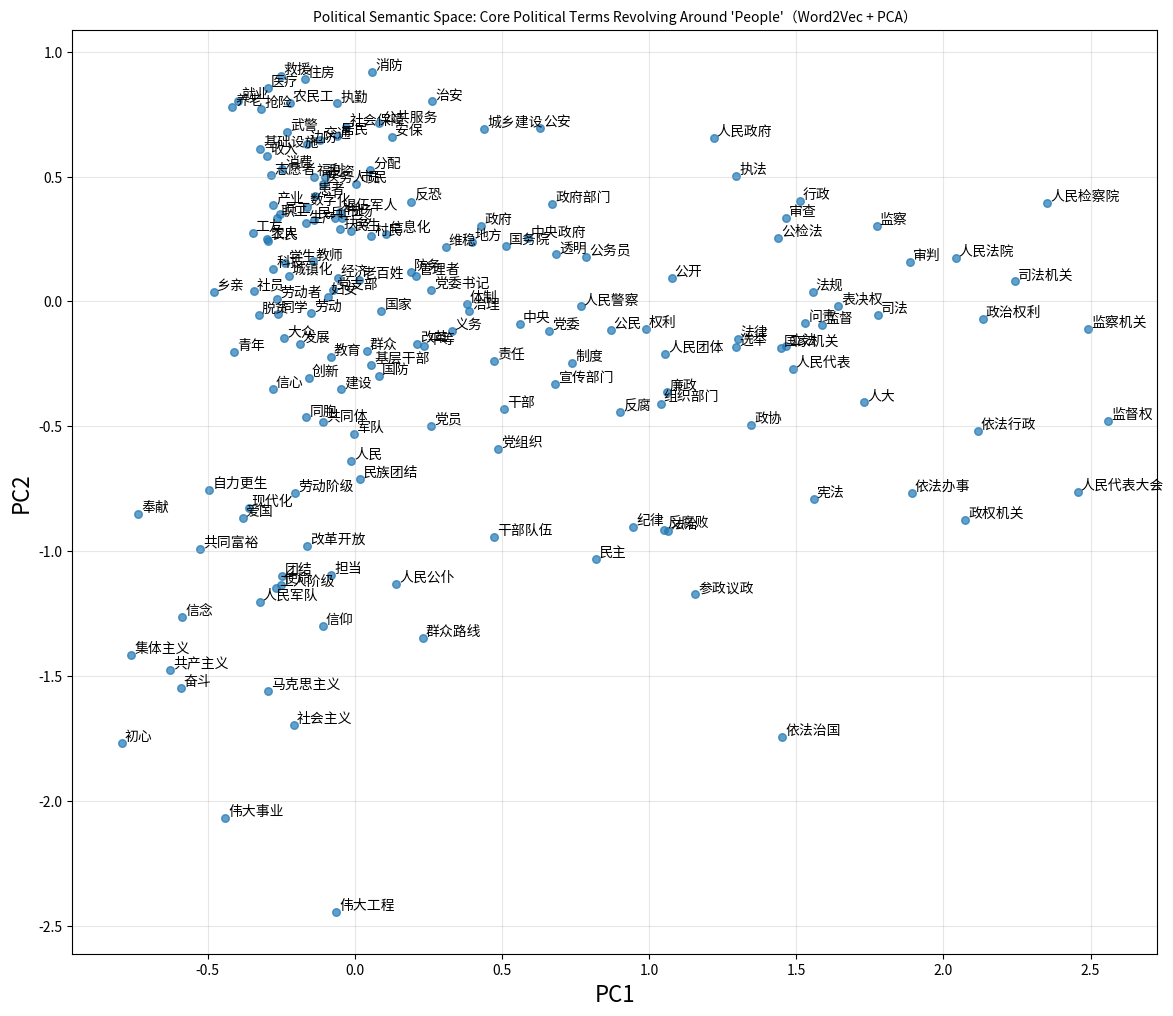

In [32]:
plt.figure(figsize=(14, 12))
plt.scatter(pdf["PC1"], pdf["PC2"], s=30, alpha=0.7)

for _, row in pdf.iterrows():
    plt.text(row["PC1"]+0.01, row["PC2"]+0.01, row["word"],
             fontsize=10, fontproperties=zh_font)

plt.title("Political Semantic Space: Core Political Terms Revolving Around 'People'（Word2Vec + PCA）", 
          fontsize=20, fontproperties=zh_font)
plt.xlabel("PC1", fontsize=16, fontproperties=zh_font)
plt.ylabel("PC2", fontsize=16, fontproperties=zh_font)
plt.grid(alpha=0.3)
plt.show()

The scree plot and cumulative explained variance curve show that PC1 explains approximately 9%, PC2 approximately 6%, and PC3 to PC10 each contribute 2% to 5%. The cumulative variance curve shows a slow upward trend rather than a sharp rise, indicating that the semantic space is inherently high-dimensional. This is consistent with the characteristics of Word2Vec embeddings, where semantic information is distributed across multiple dimensions rather than concentrated in a few orthogonal factors.

Explained variance per PC (Top10): [0.09019887 0.06419377 0.05804403 0.04919009 0.04276928 0.03794403
 0.03100779 0.02863645 0.02593213 0.02322507]
Cumulative explained variance (Top10): [0.09019887 0.15439264 0.21243667 0.26162677 0.30439605 0.34234008
 0.37334788 0.40198433 0.42791646 0.45114153]
To achieve 80% explanation of variance, the first 37 principal components are required.


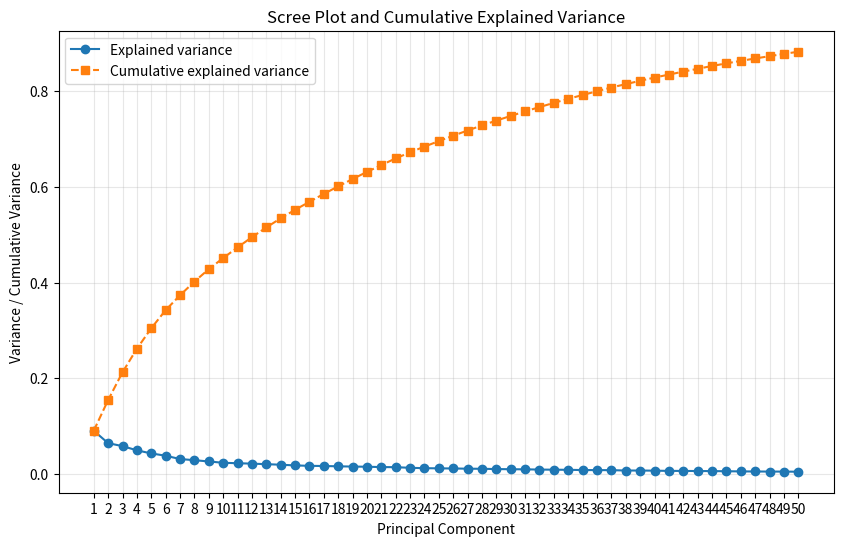

In [33]:
K = 50

pca_full = PCA(k=K, inputCol="features", outputCol="pca_features_full")
pca_full_model = pca_full.fit(vecs_sub)

ev = np.array(pca_full_model.explainedVariance.toArray())  # shape = (K,)
cum_ev = np.cumsum(ev)

print("Explained variance per PC (Top10):", ev[:10])
print("Cumulative explained variance (Top10):", cum_ev[:10])

def find_k_for_threshold(th):
    idx = np.where(cum_ev >= th)[0]
    return int(idx[0] + 1) if len(idx) > 0 else None

k80 = find_k_for_threshold(0.80)
print(f"To achieve 80% explanation of variance, the first {k80} principal components are required.")

pcs = np.arange(1, K+1)

plt.figure(figsize=(10, 6))

# Left axis: Explained variance per PC
plt.plot(pcs, ev, marker="o", label="Explained variance")

# Right axis: Cumulative explained variance
plt.plot(pcs, cum_ev, marker="s", linestyle="--", label="Cumulative explained variance")

plt.xlabel("Principal Component")
plt.ylabel("Variance / Cumulative Variance")
plt.title("Scree Plot and Cumulative Explained Variance")

plt.xticks(pcs) 
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [34]:
# 3D PCA
pca3 = PCA(k=3, inputCol="features", outputCol="pca_features_3d")
pca3_model = pca3.fit(vecs_sub)
pca3_out = pca3_model.transform(vecs_sub)

pca3_out = (
    pca3_out
        .withColumn("pca_arr", vector_to_array("pca_features_3d"))
        .withColumn("PC1", F.col("pca_arr")[0])
        .withColumn("PC2", F.col("pca_arr")[1])
        .withColumn("PC3", F.col("pca_arr")[2])
        .select("word", "PC1", "PC2", "PC3")
)

pdf3 = pca3_out.toPandas()
print(pca3_model.explainedVariance) 


[0.090198872859486,0.06419377081899111,0.05804403067887265]


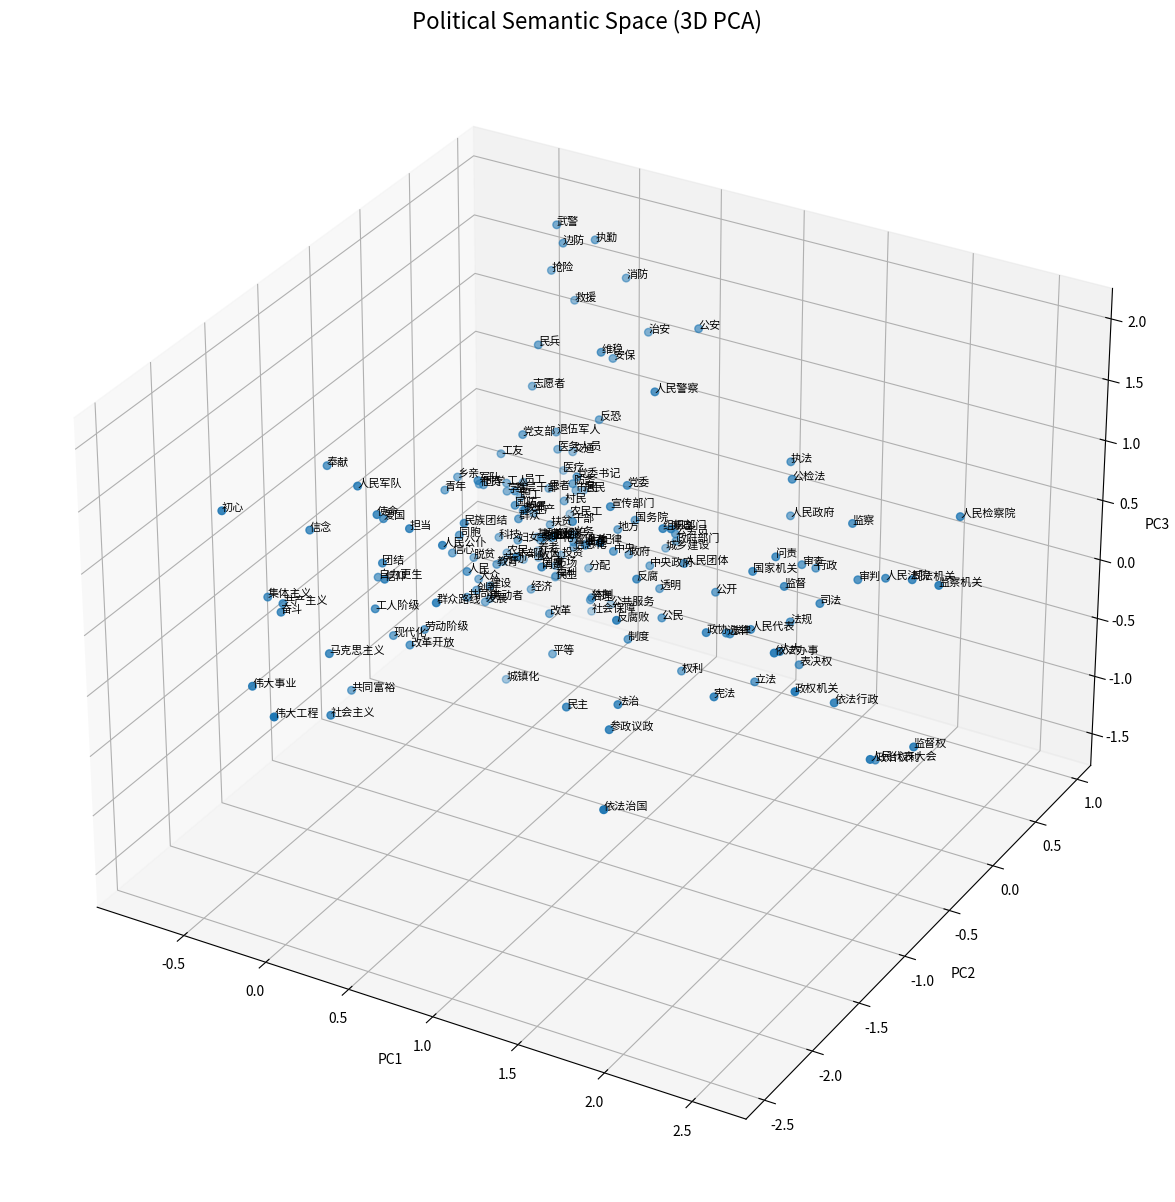

In [35]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pdf3["PC1"], pdf3["PC2"], pdf3["PC3"], s=30)

for _, row in pdf3.iterrows():
    ax.text(row["PC1"], row["PC2"], row["PC3"], row["word"],
            fontsize=8, fontproperties=zh_font)

ax.set_xlabel("PC1", fontproperties=zh_font)
ax.set_ylabel("PC2", fontproperties=zh_font)
ax.set_zlabel("PC3", fontproperties=zh_font)
ax.set_title("Political Semantic Space (3D PCA)", fontproperties=zh_font, fontsize=16)

plt.show()


Compared to two-dimensional projection, three-dimensional PCA visualization more richly reveals the semantic relationships between key political concepts while maintaining interpretability. Highlighted terms cluster into coherent semantic regions, reflecting different domains of contemporary Chinese political discourse. Similar to the two-dimensional diagram, PC1 continues to distinguish ideological/mass political terms (e.g., "socialism," "party spirit," "people") from institutional and administrative terms (e.g., "public security," "law enforcement," "judiciary," "government departments"). PC2, located on the horizontal depth axis, distinguishes the language of collective development and mobilization (e.g., "reform and opening up," "vanguard," "struggle") from the language of supervision, discipline, or coercive governance (e.g., "public security," "public order," "rule of law").

The inclusion of PC3 introduces a deeper semantic contrast, capturing variations that cannot be presented in the two-dimensional layout. The third principal component appears to distinguish between normative ideological concepts (e.g., "advanced nature," "ideal beliefs," "socialism") and actual administrative or organizational entities (e.g., "military," "public security," "cadres"). Concepts related to governance institutions tend to have higher values ​​on PC3, while ideological concepts have lower values. This separation of terms in three-dimensional space confirms that the People's Daily's political discourse encompasses multiple independent semantic axes—ideology, forms of governance, and administrative functions—that cannot be fully summarized by just two principal components.

**Overall, the three-dimensional principal component analysis plot shows that the word "people" lies at the intersection of ideology, organization, and governance-related terms, reflecting its hybrid role in Chinese political discourse as both an ideological symbol and an administrative designation.** While PCA itself compresses the high-dimensional semantic space, the three-dimensional projection reveals additional structures hidden in the two-dimensional space, demonstrating how political concepts cluster into meaningful subdomains within the broader national language.

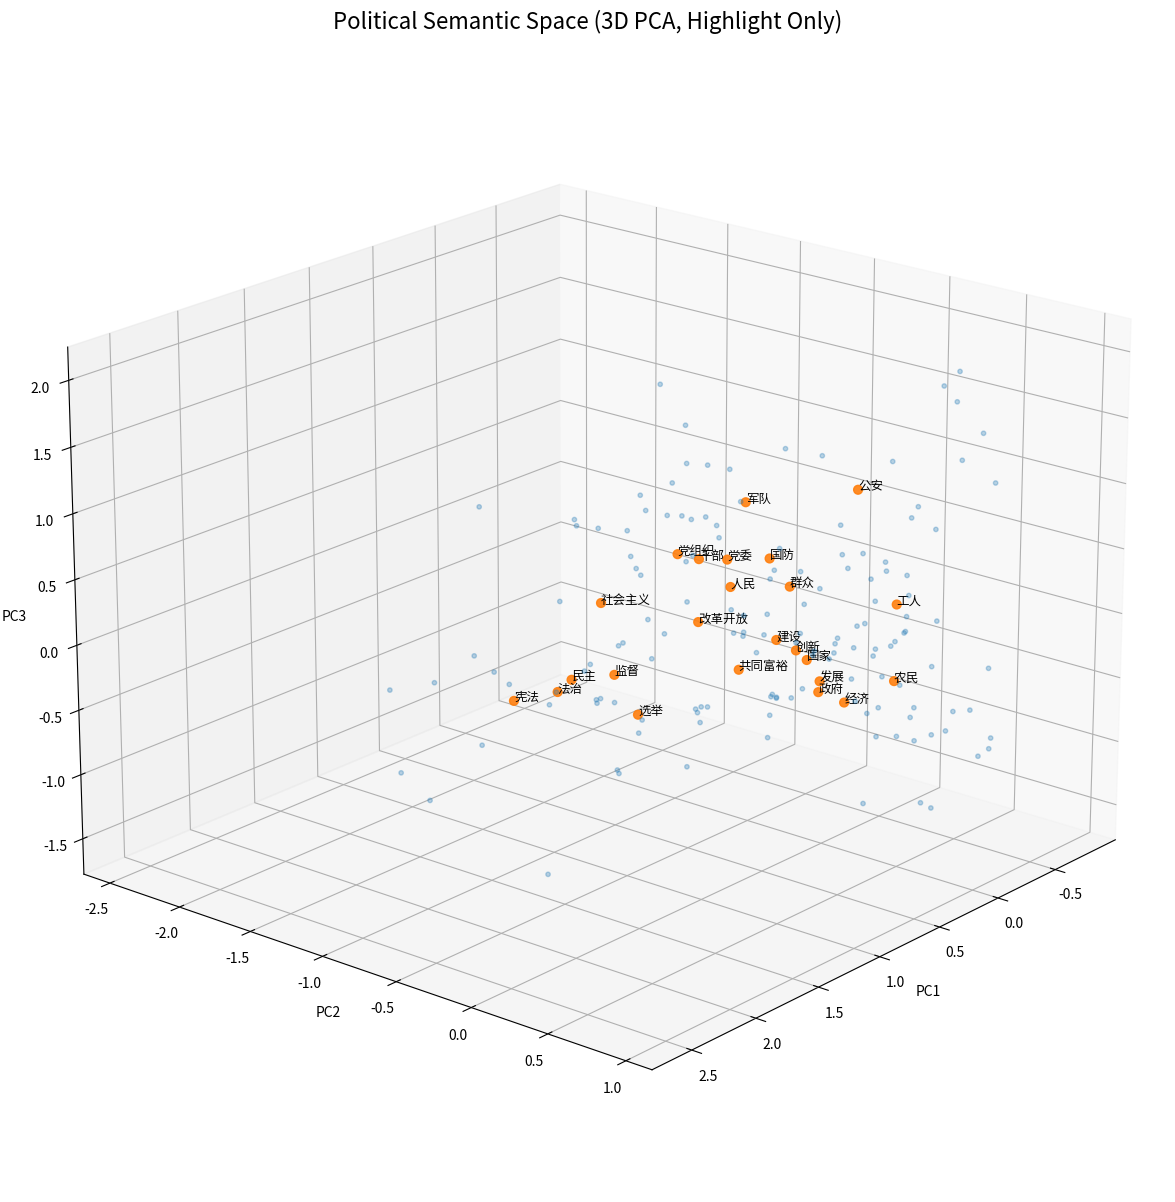

In [36]:
highlight_words = [
    "人民","群众","工人","农民","干部",
    "国家","政府","党中央","党委","党组织",
    "民主","法治","宪法","选举","监督",
    "发展","建设","改革开放","经济","创新",
    "社会主义","新时代","共同富裕","民族复兴",
    "安全","稳定","军队","公安","国防"
]

pdf3["highlight"] = pdf3["word"].isin(highlight_words)

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection="3d")

bg = pdf3[~pdf3["highlight"]]
ax.scatter(bg["PC1"], bg["PC2"], bg["PC3"],
           s=10, alpha=0.3)

fg = pdf3[pdf3["highlight"]]
ax.scatter(fg["PC1"], fg["PC2"], fg["PC3"],
           s=40, alpha=0.9)

for _, row in fg.iterrows():
    ax.text(row["PC1"], row["PC2"], row["PC3"], row["word"],
            fontsize=9, fontproperties=zh_font)

ax.set_xlabel("PC1", fontproperties=zh_font)
ax.set_ylabel("PC2", fontproperties=zh_font)
ax.set_zlabel("PC3", fontproperties=zh_font)
ax.set_title("Political Semantic Space (3D PCA, Highlight Only)",
             fontproperties=zh_font, fontsize=16)

ax.view_init(elev=20, azim=40)

plt.show()


# Reflect on Social/Cultural Implications of your findings

PCA provides an important social and cultural perspective for understanding how the political concept of "the people" is embedded in the semantic structure of Chinese political discourse. It offers a crucial benchmark for understanding the meaning structure of the concept of "the people" in specific historical periods, thus helping us interpret the transformation of its meaning over time.

Two main principal components reveal a semantic field organized along two major axes of political meaning. PC1 distinguishes between ideology-mass politics and institutional-legal governance, while PC2 contrasts collectivist-development discourse with administrative, supervisory, and security-oriented language. This structure reflects the long-standing duality in modern Chinese political culture: "the people" is both the symbolic subject of revolutionary ideology and the administrative object of the state apparatus. Its semantic position—between "masses" and "public servants," and adjacent to terms like "people's government" and "law enforcement"—embodies this hybrid state. This suggests that "the people" is not only a normative ideal but also a bureaucratic category rooted in governance practices.

These findings resonate with theoretical discussions in Chinese political studies regarding the coexistence of the legitimacy of the mass line and institutionalized state governance. PCA reveals a statistical pattern reflecting deep-seated political and cultural tensions: the contradiction between the people as a mobilizable collective and the people as a governed group. This dual structure also provides a perspective for interpreting semantic changes. For example, if diachronic analysis shows that the term "people" is gradually converging towards legal and administrative terms, it may reflect the increasing bureaucratization and institutionalization of political discourse. Conversely, a shift towards ideological clusters may indicate a renewed emphasis on mass politics and ideological mobilization.

**Therefore, PCA not only depicts the semantic space of the term "people" but also highlights the cultural contradictions inherent in the concept itself, providing a theoretical foundation for subsequent longitudinal analysis.**